# Wolfram Marlowe Smart Contract Execution - Milestone 1

#### Proof of completion for the Project Catalyst proposal 1100291

### Executive Summary

This document outlines the operation of a specialized oracle validator designed to supply financial information for Marlowe contracts via a `Choice` Input. The process involves two key steps. If the oracle cannot answer the petition, a timeout policy has been implemented. 

### Normal workflow

#### 1. Oracle Contract Deployment 
The initial step involves the allocation of the payment and the provision of information regarding the Marlowe contract, the requested data and timeout parameters. The datum is structured as follow:

```
oracleDatum = {
       transactionId :: TxId,
       transactionIndex :: Integer,
       choiceToSolve :: BuiltinByteString,
       dataTag :: BuiltinByteString,
       deadline:: POSIXTime,
       beneficiaryAfterDeadline:: PubKeyHash
}
```

In this schema, `transactionId` and `transactionIndex` identify the Marlowe contract awaiting a choice. The `choiceToSolve` field specifies the name of the choice within the Marlowe contract context, while `dataTag` is a code that identifies the specific information the user wants to retrieve from the price feed service. The final two fields, deadline and beneficiary, are essential for validating the timeout policy and will be explained later.

The deployment diagrams is showed.
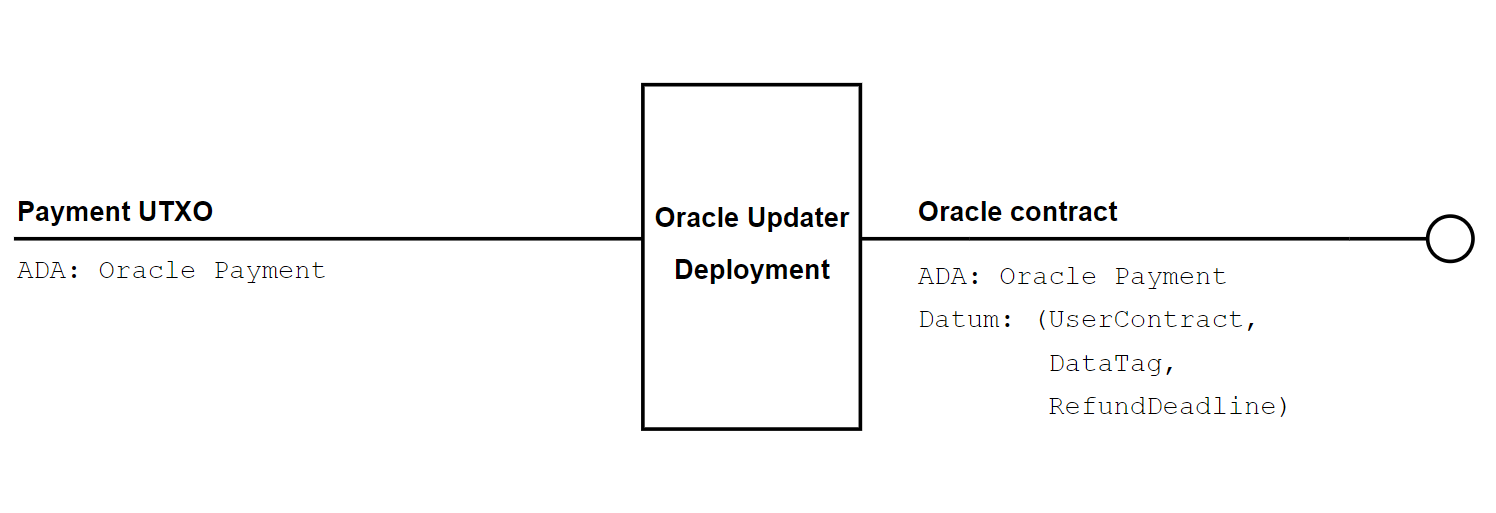

#### 2. Oracle Choice Transaction
To provide a response, the oracle must consume both the Oracle contract and the Marlowe contract within the same transaction. During execution, the oracle contract must satisfy the following conditions:

1. The Marlowe contract must be present in the transaction context.
2. The transaction must resolve the choice whose name matches the choiceToSolve field in the datum.
3. The transaction must be executed before the specified deadline.

When all conditions are met, the ADA locked within the contract is redirected to the oracle wallet, allowing the Marlowe contract to proceed to its next step as showed in the image below.
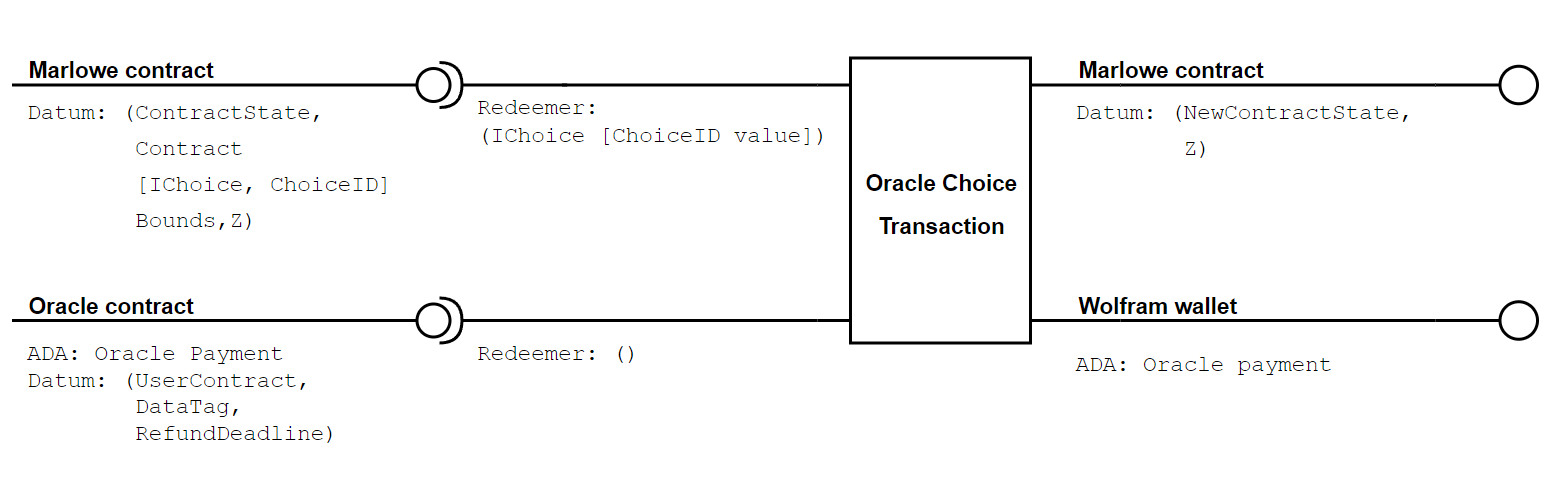


### Timeout Policy

If the oracle is unable to provide the requested price feed data, the timeout policy permits the `beneficiaryAfterDeadline` to claim the ADA held within the Oracle Contract at any time following the deadline. To claim it, the beneficiary must be specified as "required signer" in the transaction that consumes the UTXO.

### Execution Index

1. [Initialization](#initialization)
2. [Contract Preparation](#paragraph1)
3. [Transaction 1: Marlowe Contract Creation](#transaction1)
4. [Transaction 2: Marlowe Deposit](#transaction2)
5. [Transaction 3: Oracle Updater Deployment](#transaction3)
6. [Transaction 4: Oracle Choice Transaction](#transaction4)
7. [Transaction 5: Notify and Close Marlowe Contract](#transaction5)
8. [Transaction 6: Deploy Oracle with Small Deadline](#transaction6)
9. [Transaction 7: Consume Oracle After Deadline](#transaction7)

## Initialization  <a name="initialization"></a>
### Environment and versions
Standard tools from *[Marlowe starter kit](https://github.com/input-output-hk/marlowe-starter-kit/tree/main)*. Notice the use of the "preprod" testnet. 

In [1]:
source ../scripts/check-tools-and-env.sh

########################
## Check CLI commands ##
########################

The following required programs are available in the shell:
  * jq
  * json2yaml
  * marlowe-cli
  * marlowe-runtime-cli
  * cardano-cli
  * cardano-address
  * cardano-wallet

#########################
## Check required envs ##
#########################

The following environment variables are available in the shell:
  * CARDANO_NODE_SOCKET_PATH = /ipc/node.socket
  * MARLOWE_RT_HOST = proxy
  * MARLOWE_RT_PORT = 3700
  * MARLOWE_RT_WEBSERVER_HOST = web-server
  * MARLOWE_RT_WEBSERVER_PORT = 3780
  * MARLOWE_RT_WEBSERVER_URL = http://web-server:3780

###################
## Check Network ##
###################

The NETWORK is set to preprod
CARDANO_TESTNET_MAGIC = 1
CARDANO_SCAN_URL = https://preprod.cardanoscan.io
MARLOWE_SCAN_URL = https://preprod.marlowescan.com


In [2]:
marlowe-cli --version
cardano-cli --version

marlowe-cli 0.2.0.0
cardano-cli 8.1.2 - linux-x86_64 - ghc-8.10
git rev d2d90b48c5577b4412d5c9c9968b55f8ab4b9767


### Utilities

Function to select a UTXO based on a minimun quantity.

In [3]:
function select_utxo {
marlowe-cli util select \
  --testnet-magic 1 \
  --lovelace-only "$1" \
  "$PAYMENT_ADDR" \
| sed -n -e 's/^TxIn "\(.*\)" (TxIx \(.*\))$/\1#\2/;1p'
}

### Credentials

Load and store keys and address in respective variables

In [4]:
export KEYS=./credentials
PAYMENT_SKEY=$KEYS/lender.skey
PAYMENT_ADDR=$(cat $KEYS/lender.address)
echo "PAYMENT_ADDR=$PAYMENT_ADDR"

PAYMENT_ADDR=addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l


### Constants
Ada to Lovelace equivalence

In [5]:
ADA=1000000

### POSIX Milliseconds and Slots

Constants to calculate validity intervals for Marlowe transactions.

In [6]:
SLOT_LENGTH=$(marlowe-cli util slotting --testnet-magic 1| jq -r .scSlotLength)
SLOT_ZERO_TIME=$(marlowe-cli util slotting --testnet-magic 1| jq -r .scSlotZeroTime)
echo "SLOT_LENGTH = $SLOT_LENGTH"
echo "SLOT_ZERO_TIME = $SLOT_ZERO_TIME"

SLOT_LENGTH = 1000
SLOT_ZERO_TIME = 1655683200000


### Unit File
File to be used as redeemer when consuming Oracle Contract

In [7]:
yaml2json << EOI > unit.json
constructor: 0
fields: []
EOI
cat unit.json

{"constructor":0,"fields":[]}


## Marlowe contract preparation <a name="preparation"></a>

### Initial Contract

Simple Marlowe contract. Receives a deposit, waits for a choice and closes with a notification.

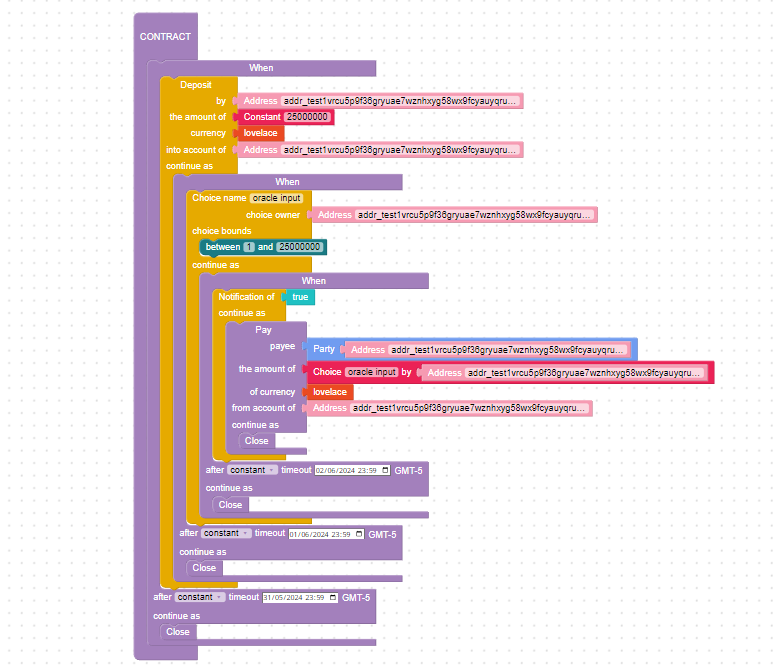

### Marlowe Validator Address
Storing Marlowe Semantics Validator address and reference script UTXO into variables.

In [8]:
marlowe-cli contract validator \
  --testnet-magic 1 \
  --out-file /dev/null \
  --print-hash

addr_test1wpsz02qpp3245nwkkzyg9wye7je3vlrwg5jqgufjyqkanpqef22lm

Validator hash: "6027a8010c555a4dd6b08882b899f4b3167c6e4524047132202dd984"


In [9]:
MARLOWE_ADDR=$(marlowe-cli contract address --testnet-magic 1 )
echo "MARLOWE_ADDR = $MARLOWE_ADDR"

MARLOWE_ADDR = addr_test1wpsz02qpp3245nwkkzyg9wye7je3vlrwg5jqgufjyqkanpqef22lm


In [10]:
UTXO_MARLOWE_SCRIPT=$(
marlowe-cli transaction find-published \
  --testnet-magic 1 \
  2> /dev/null \
| jq -r .marlowe.txIn
)
echo $UTXO_MARLOWE_SCRIPT

6887579ed3f0e34e6f6949a0827b19b6d0ab7895e4e7f6049985548cc2a76095#1


### Contract
Definition of deadlines for each input in the contract and create the .contract file.

In [11]:
PAYMENT_DEADLINE=$((1000 * $(date -d "$(date -u) + 8 days" +%s))) #deadline
CHOICE_DEADLINE=$((1000 * $(date -d "$(date -u) + 9 days" +%s))) #deadline
NOTIFY_DEADLINE=$((1000 * $(date -d "$(date -u) + 10 days" +%s))) #deadline

In [12]:
yaml2json << EOI > tx-1.contract
timeout: $PAYMENT_DEADLINE
timeout_continuation: close
when:
- case:
    deposits: 25000000
    into_account:
      address: $PAYMENT_ADDR
    of_token:
      currency_symbol: ''
      token_name: ''
    party:
      address: $PAYMENT_ADDR
  then:
    timeout: $CHOICE_DEADLINE
    timeout_continuation: close
    when:
    - case:
        choose_between:
        - from: 1
          to: 25000000
        for_choice:
          choice_name: oracle input
          choice_owner:
            address: $PAYMENT_ADDR
      then:
        timeout: $NOTIFY_DEADLINE
        timeout_continuation: close
        when:
        - case:
            notify_if: true
          then:
            from_account:
              address: $PAYMENT_ADDR
            pay:
              value_of_choice:
                choice_name: oracle input
                choice_owner:
                  address: $PAYMENT_ADDR
            then: close
            to:
              party:
                address: $PAYMENT_ADDR
            token:
              currency_symbol: ''
              token_name: ''
EOI
json2yaml tx-1.contract

timeout: 1717889343000
timeout_continuation: close
when:
- case:
    deposits: 25000000
    into_account:
      address: addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l
    of_token:
      currency_symbol: ''
      token_name: ''
    party:
      address: addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l
  then:
    timeout: 1717975743000
    timeout_continuation: close
    when:
    - case:
        choose_between:
        - from: 1
          to: 25000000
        for_choice:
          choice_name: oracle input
          choice_owner:
            address: addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l
      then:
        timeout: 1718062143000
        timeout_continuation: close
        when:
        - case:
            notify_if: true
          then:
            from_account:
              address: addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l
            pay:
              value_of_choice:
                choice_name: or

### State

Creation of initial state for the contract.

In [13]:
INITIAL_LOVELACE=$((3 * ADA))

In [14]:
yaml2json << EOI > tx-1.state
accounts:
- - - address: $PAYMENT_ADDR
    - currency_symbol: ''
      token_name: ''
  - $INITIAL_LOVELACE
boundValues: []
choices: []
minTime: 1
EOI
cat tx-1.state

{"accounts":[[[{"address":"addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l"},{"currency_symbol":"","token_name":""}],3000000]],"boundValues":[],"choices":[],"minTime":1}


## Transaction 1: Marlowe Contract Creation <a name="transaction1"></a>

The transactions are constructed manually since Marlowe's available tools do not support including auxiliary inputs and outputs. Datums and redeemers will be created using marlowe-cli.

In [15]:
marlowe-cli run initialize \
  --testnet-magic 1 \
  --contract-file tx-1.contract \
  --state-file tx-1.state \
  --out-file tx-1.marlowe

In [16]:
marlowe-cli contract datum \
  --contract-file tx-1.contract \
  --state-file tx-1.state \
  --out-file tx-1.datum

feb0f9953ed0439baacfbc79ade307eac770e079fcdfe3bae600f7325e3fec65


In [17]:
#we select the first input manually.
TX_1_IN="$(select_utxo $((100 * ADA)))"
echo "TX_1_IN = $TX_1_IN"

TX_1_IN = cb85401c4e8868792da0f147d8e5445e9362a572aba5dd7ce3af0dd253a24297#2


Build and submit the contract creation transaction.

In [18]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in $TX_1_IN \
  --tx-out "$MARLOWE_ADDR+$INITIAL_LOVELACE" \
    --tx-out-datum-embed-file tx-1.datum \
  --change-address $PAYMENT_ADDR \
  --out-file tx-1.unsigned

Estimated transaction fee: Lovelace 192429


In [19]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-1.unsigned \
  --out-file tx-1.signed

In [20]:
TX_1=$(cardano-cli transaction txid --tx-file tx-1.signed)
echo "TX_1 = $TX_1"

TX_1 = ef4a30d7f3a2edcc22d4450a4e2b1cb8f192e7ea9e8a2982470e2b7bc8f96ea0


In [21]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-1.signed

Transaction successfully submitted.


In [22]:
echo "$CARDANO_SCAN_URL/transaction/$TX_1?tab=summary"

https://preprod.cardanoscan.io/transaction/ef4a30d7f3a2edcc22d4450a4e2b1cb8f192e7ea9e8a2982470e2b7bc8f96ea0?tab=summary


## Transaction 2: Marlowe Deposit  <a name="transaction2"></a>

Executing the deposit transaction.

In [23]:
DEPOSIT_LOVELACE=$((25 * ADA))

In [24]:
TX_2_INVALID_BEFORE=$((1000 * ($(date -u +%s) - 60)))
TX_2_INVALID_HEREAFTER=$((1000 * ($(date -u +%s) + 300)))
echo "TX_2_INVALID_BEFORE = $TX_2_INVALID_BEFORE"
echo "TX_2_INVALID_HEREAFTER = $TX_2_INVALID_HEREAFTER"

TX_2_INVALID_BEFORE = 1717198276000
TX_2_INVALID_HEREAFTER = 1717198636000


In [25]:
marlowe-cli run prepare \
  --deposit-account $PAYMENT_ADDR \
  --deposit-party $PAYMENT_ADDR \
  --deposit-amount $DEPOSIT_LOVELACE \
  --invalid-before $TX_2_INVALID_BEFORE \
  --invalid-hereafter $TX_2_INVALID_HEREAFTER \
  --marlowe-file tx-1.marlowe \
  --out-file tx-2.marlowe

Rounding  `TransactionInput` txInterval boundaries to:(POSIXTime {getPOSIXTime = 1717198276000},POSIXTime {getPOSIXTime = 1717198636999})
TransactionInput {txInterval = (POSIXTime {getPOSIXTime = 1717198276000},POSIXTime {getPOSIXTime = 1717198636999}), txInputs = [NormalInput (IDeposit "\"addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l\"" "\"addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l\"" (Token "" "") 25000000)]}


In [26]:
jq '.tx.inputs[0]' tx-2.marlowe > tx-2.inputs
marlowe-cli contract redeemer \
  --input-file tx-2.inputs \
  --out-file tx-2.redeemer

In [27]:
jq .tx.contract tx-2.marlowe > tx-2.contract
jq .tx.state tx-2.marlowe > tx-2.state
marlowe-cli contract datum \
  --contract-file tx-2.contract \
  --state-file tx-2.state \
  --out-file tx-2.datum

e4042d39977837360a9c75ff13fee384602331968fe31d2fc4bf7e83d6e6d26d


In [28]:
DEPOSIT_INPUT="$TX_1#1"
echo "DEPOSIT_INPUT = $DEPOSIT_INPUT"

DEPOSIT_INPUT = ef4a30d7f3a2edcc22d4450a4e2b1cb8f192e7ea9e8a2982470e2b7bc8f96ea0#1


Build and submit the deposit transaction.

In [29]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in-collateral "$DEPOSIT_INPUT" \
  --tx-in "$DEPOSIT_INPUT" \
  --tx-in "$TX_1#0" \
    --spending-tx-in-reference "$UTXO_MARLOWE_SCRIPT" \
    --spending-plutus-script-v2 \
    --spending-reference-tx-in-datum-file tx-1.datum \
    --spending-reference-tx-in-redeemer-file tx-2.redeemer \
  --tx-out "$MARLOWE_ADDR+$((INITIAL_LOVELACE+DEPOSIT_LOVELACE))" \
    --tx-out-datum-embed-file tx-2.datum \
  --change-address $PAYMENT_ADDR \
  --required-signer $PAYMENT_SKEY \
  --invalid-before $(((TX_2_INVALID_BEFORE - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --invalid-hereafter $(((TX_2_INVALID_HEREAFTER - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --out-file tx-2.unsigned

Estimated transaction fee: Lovelace 509095


In [30]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-2.unsigned \
  --out-file tx-2.signed

In [31]:
## this is the transaction that must be solved
TX_2=$(cardano-cli transaction txid --tx-file tx-2.signed)
echo "TX_2 = $TX_2"

TX_2 = 3efda36ed9b87756dd3eb2c8c0ea7ef4b4ba5628c2fce7c17d52448181b773cc


In [32]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-2.signed

Transaction successfully submitted.


In [33]:
echo "$CARDANO_SCAN_URL/transaction/$TX_2?tab=summary"

https://preprod.cardanoscan.io/transaction/3efda36ed9b87756dd3eb2c8c0ea7ef4b4ba5628c2fce7c17d52448181b773cc?tab=summary


## Transaction 3: Oracle Updater Deployment  <a name="transaction3"></a>
### Oracle Contract Address and Payment

Store Oracle Contract address and define how much ADA it will hold as payment for the service.

In [34]:
ORACLE_ADDR=$(cardano-cli address build --testnet-magic 1 --payment-script-file wolframOracleUpdater.plutus)
echo "ORACLE_ADDR = $ORACLE_ADDR"

ORACLE_ADDR = addr_test1wrndcvjv0eh4h6z4542pshfd84sa9dxpz0neztq6rppwvwg2h9054


In [35]:
ORACLE_PAYMENT=$((5 * ADA))
echo "ORACLE_PAYMENT=$ORACLE_PAYMENT"

ORACLE_PAYMENT=5000000


### Create "oracle.datum" File  

In [36]:
TX_ID=$TX_2 #tx to be solved
TX_IDX=0    #index to be solved
ORACLE_DL=$((1000 * $(date -d "$(date -u) + 90 minutes" +%s))) #deadline to apply choice before refund
echo "TX_ID=$TX_ID"
echo "TX_IDX=$TX_IDX"
echo "ORACLE_DL=$ORACLE_DL"

TX_ID=3efda36ed9b87756dd3eb2c8c0ea7ef4b4ba5628c2fce7c17d52448181b773cc
TX_IDX=0
ORACLE_DL=1717203953000


In [37]:
yaml2json << EOI > wolframOracleUpdater.datum
constructor: 0
fields:
- constructor: 0
  fields:
  - bytes: "$TX_ID"
- int: $TX_IDX
- bytes: "6f7261636c6520696e707574" #oracle input
- bytes: "414441555344"             #adausd
- int: $ORACLE_DL
- bytes: "f1ca04a98e903273b9f3853b9888a1dc62a704ef0801f04b3e71538b"
EOI
cat wolframOracleUpdater.datum

{"constructor":0,"fields":[{"constructor":0,"fields":[{"bytes":"3efda36ed9b87756dd3eb2c8c0ea7ef4b4ba5628c2fce7c17d52448181b773cc"}]},{"int":0},{"bytes":"6f7261636c6520696e707574"},{"bytes":"414441555344"},{"int":1717203953000},{"bytes":"f1ca04a98e903273b9f3853b9888a1dc62a704ef0801f04b3e71538b"}]}


### Build Transaction

Build and submit the Oracle Contract creation transaction.

In [38]:
ORACLE_INPUT="$TX_2#1"
echo $ORACLE_INPUT

3efda36ed9b87756dd3eb2c8c0ea7ef4b4ba5628c2fce7c17d52448181b773cc#1


In [39]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in "$ORACLE_INPUT" \
  --tx-out "$ORACLE_ADDR+$ORACLE_PAYMENT" \
    --tx-out-datum-embed-file wolframOracleUpdater.datum \
  --change-address $PAYMENT_ADDR \
  --out-file tx-3.unsigned

Estimated transaction fee: Lovelace 173465


In [40]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-3.unsigned \
  --out-file tx-3.signed

In [41]:
TX_3=$(cardano-cli transaction txid --tx-file tx-3.signed)
echo "TX_3 = $TX_3"

TX_3 = 04b62b843a761ce9f811d9e44fd1bbe0688aedfb98445defc50fb7a065b98afe


In [42]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-3.signed

Transaction successfully submitted.


In [43]:
echo "$CARDANO_SCAN_URL/transaction/$TX_3?tab=summary"

https://preprod.cardanoscan.io/transaction/04b62b843a761ce9f811d9e44fd1bbe0688aedfb98445defc50fb7a065b98afe?tab=summary


## Transaction 4: Oracle Choice Transaction  <a name="transaction4"></a>

Create transaction to apply the choice to the Marlowe contract and consume the Oracle.

In [44]:
CHOICE=$((15 * ADA))
echo "CHOICE = $CHOICE"

CHOICE = 15000000


In [45]:
TX_4_INVALID_BEFORE=$((1000 * ($(date -u +%s) - 60)))
TX_4_INVALID_HEREAFTER=$((1000 * ($(date -u +%s) + 300)))
echo "TX_4_INVALID_BEFORE = $TX_4_INVALID_BEFORE"
echo "TX_4_INVALID_HEREAFTER = $TX_4_INVALID_HEREAFTER"

TX_4_INVALID_BEFORE = 1717198705000
TX_4_INVALID_HEREAFTER = 1717199065000


In [46]:
marlowe-cli run prepare \
  --choice-name "oracle input" \
  --choice-party $PAYMENT_ADDR \
  --choice-number $CHOICE \
  --invalid-before $TX_4_INVALID_BEFORE \
  --invalid-hereafter $TX_4_INVALID_HEREAFTER \
  --marlowe-file tx-2.marlowe \
  --out-file tx-4.marlowe

Rounding  `TransactionInput` txInterval boundaries to:(POSIXTime {getPOSIXTime = 1717198705000},POSIXTime {getPOSIXTime = 1717199065999})
TransactionInput {txInterval = (POSIXTime {getPOSIXTime = 1717198705000},POSIXTime {getPOSIXTime = 1717199065999}), txInputs = [NormalInput (IChoice (ChoiceId "oracle input" "\"addr_test1vrcu5p9f36gryuae7wznhxyg58wx9fcyauyqruzt8ec48zctqyq5l\"") 15000000)]}


In [47]:
jq '.tx.inputs[0]' tx-4.marlowe > tx-4.inputs
marlowe-cli contract redeemer \
  --input-file tx-4.inputs \
  --out-file tx-4.redeemer

In [48]:
jq .tx.contract tx-4.marlowe > tx-4.contract
jq .tx.state tx-4.marlowe > tx-4.state
marlowe-cli contract datum \
  --contract-file tx-4.contract \
  --state-file tx-4.state \
  --out-file tx-4.datum

dfcbae9679d0b84bb666f53c9f2be4ca17523a88ff53bb97edce0d2577ceff7e


In [49]:
CHOICE_INPUT="$TX_3#1"
echo "CHOICE_INPUT=$CHOICE_INPUT"

CHOICE_INPUT=04b62b843a761ce9f811d9e44fd1bbe0688aedfb98445defc50fb7a065b98afe#1


Build and submit the choice transaction.

In [50]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in-collateral "$CHOICE_INPUT" \
  --tx-in "$CHOICE_INPUT" \
  --tx-in "$TX_2#0" \
    --spending-tx-in-reference "$UTXO_MARLOWE_SCRIPT" \
    --spending-plutus-script-v2 \
    --spending-reference-tx-in-datum-file tx-2.datum \
    --spending-reference-tx-in-redeemer-file tx-4.redeemer \
  --tx-in "$TX_3#0" \
    --tx-in-script-file wolframOracleUpdater.plutus \
    --tx-in-datum-file wolframOracleUpdater.datum \
    --tx-in-redeemer-file unit.json \
  --tx-out "$MARLOWE_ADDR+$((INITIAL_LOVELACE+DEPOSIT_LOVELACE))" \
    --tx-out-datum-embed-file tx-4.datum \
  --tx-out "$PAYMENT_ADDR+$((ORACLE_PAYMENT))" \
  --change-address $PAYMENT_ADDR \
  --required-signer $PAYMENT_SKEY \
  --invalid-before $(((TX_4_INVALID_BEFORE - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --invalid-hereafter $(((TX_4_INVALID_HEREAFTER - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --out-file tx-4.unsigned

Estimated transaction fee: Lovelace 1009436


In [51]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-4.unsigned \
  --out-file tx-4.signed

In [52]:
TX_4=$(cardano-cli transaction txid --tx-file tx-4.signed)
echo "TX_4 = $TX_4"

TX_4 = b1aaea16812ef6281f258af93f36219e76ef6ea61fe790bb7b731a64c9cdca07


In [53]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-4.signed

Transaction successfully submitted.


In [54]:
echo "$CARDANO_SCAN_URL/transaction/$TX_4?tab=summary"

https://preprod.cardanoscan.io/transaction/b1aaea16812ef6281f258af93f36219e76ef6ea61fe790bb7b731a64c9cdca07?tab=summary


## Transaction 5: Notify and Close Marlowe Contract  <a name="transaction5"></a>

Closure of Marlowe contract with a `Notify` input.

In [55]:
TX_5_INVALID_BEFORE=$((1000 * ($(date -u +%s) - 60)))
TX_5_INVALID_HEREAFTER=$((1000 * ($(date -u +%s) + 300)))
echo "TX_5_INVALID_BEFORE = $TX_5_INVALID_BEFORE"
echo "TX_5_INVALID_HEREAFTER = $TX_5_INVALID_HEREAFTER"

TX_5_INVALID_BEFORE = 1717199016000
TX_5_INVALID_HEREAFTER = 1717199376000


In [56]:
marlowe-cli run prepare \
  --notify \
  --invalid-before $TX_5_INVALID_BEFORE \
  --invalid-hereafter $TX_5_INVALID_HEREAFTER \
  --marlowe-file tx-4.marlowe \
  --out-file tx-5.marlowe

Rounding  `TransactionInput` txInterval boundaries to:(POSIXTime {getPOSIXTime = 1717199016000},POSIXTime {getPOSIXTime = 1717199376999})
TransactionInput {txInterval = (POSIXTime {getPOSIXTime = 1717199016000},POSIXTime {getPOSIXTime = 1717199376999}), txInputs = [NormalInput INotify]}


In [57]:
jq '.tx.inputs[0]' tx-5.marlowe > tx-5.inputs
marlowe-cli contract redeemer \
  --input-file tx-5.inputs \
  --out-file tx-5.redeemer

In [58]:
jq .tx.contract tx-5.marlowe > tx-5.contract
jq .tx.state tx-5.marlowe > tx-5.state
marlowe-cli contract datum \
  --contract-file tx-4.contract \
  --state-file tx-4.state \
  --out-file tx-4.datum

dfcbae9679d0b84bb666f53c9f2be4ca17523a88ff53bb97edce0d2577ceff7e


In [59]:
NOTIFY_INPUT="$TX_4#2"
echo "NOTIFY_INPUT=$NOTIFY_INPUT"

NOTIFY_INPUT=b1aaea16812ef6281f258af93f36219e76ef6ea61fe790bb7b731a64c9cdca07#2


In [60]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in-collateral "$NOTIFY_INPUT" \
  --tx-in "$NOTIFY_INPUT" \
  --tx-in "$TX_4#0" \
    --spending-tx-in-reference "$UTXO_MARLOWE_SCRIPT" \
    --spending-plutus-script-v2 \
    --spending-reference-tx-in-datum-file tx-4.datum \
    --spending-reference-tx-in-redeemer-file tx-5.redeemer \
  --tx-out "$PAYMENT_ADDR+$CHOICE" \
  --tx-out "$PAYMENT_ADDR+$((INITIAL_LOVELACE+DEPOSIT_LOVELACE-CHOICE))" \
  --change-address $PAYMENT_ADDR \
  --required-signer $PAYMENT_SKEY \
  --invalid-before $(((TX_5_INVALID_BEFORE - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --invalid-hereafter $(((TX_5_INVALID_HEREAFTER - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --out-file tx-5.unsigned

Estimated transaction fee: Lovelace 455547


In [61]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-5.unsigned \
  --out-file tx-5.signed

In [62]:
TX_5=$(cardano-cli transaction txid --tx-file tx-5.signed)
echo "TX_5 = $TX_5"

TX_5 = 1b8e4bcce15259583fce01a8b19796b725b3ea85aac085884b1ff5f4df673f6e


In [63]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-5.signed

Transaction successfully submitted.


In [64]:
echo "$CARDANO_SCAN_URL/transaction/$TX_5?tab=summary"

https://preprod.cardanoscan.io/transaction/1b8e4bcce15259583fce01a8b19796b725b3ea85aac085884b1ff5f4df673f6e?tab=summary


## Timeout Policy


## Transaction 6: Deploy Oracle with Small Deadline  <a name="transaction6"></a>

Create a new Oracle Contract instance with a small deadline to test the Timeout Policy.

In [65]:
ORACLE_ADDR=$(cardano-cli address build --testnet-magic 1 --payment-script-file wolframOracleUpdater.plutus)
echo "ORACLE_ADDR = $ORACLE_ADDR"

ORACLE_ADDR = addr_test1wrndcvjv0eh4h6z4542pshfd84sa9dxpz0neztq6rppwvwg2h9054


In [66]:
TX_ID=$TX_2 #tx to be solved
TX_IDX=0    #index to be solved
ORACLE_DL=$((1000 * $(date -d "$(date -u) + 2 minutes" +%s))) #deadline to apply choice before refund
echo "TX_ID=$TX_ID"
echo "TX_IDX=$TX_IDX"
echo "ORACLE_DL=$ORACLE_DL"

TX_ID=3efda36ed9b87756dd3eb2c8c0ea7ef4b4ba5628c2fce7c17d52448181b773cc
TX_IDX=0
ORACLE_DL=1717199314000


In [67]:
yaml2json << EOI > wolframOracleUpdater.datum
constructor: 0
fields:
- constructor: 0
  fields:
  - bytes: "$TX_ID"
- int: $TX_IDX
- bytes: "6f7261636c6520696e707574" #oracle input
- bytes: "414441555344"             #adausd
- int: $ORACLE_DL
- bytes: "f1ca04a98e903273b9f3853b9888a1dc62a704ef0801f04b3e71538b"
EOI
cat wolframOracleUpdater.datum

{"constructor":0,"fields":[{"constructor":0,"fields":[{"bytes":"3efda36ed9b87756dd3eb2c8c0ea7ef4b4ba5628c2fce7c17d52448181b773cc"}]},{"int":0},{"bytes":"6f7261636c6520696e707574"},{"bytes":"414441555344"},{"int":1717199314000},{"bytes":"f1ca04a98e903273b9f3853b9888a1dc62a704ef0801f04b3e71538b"}]}


In [68]:
ORACLE_INPUT="$(select_utxo $((100 * ADA)))"
echo "ORACLE_INPUT=$ORACLE_INPUT"

ORACLE_INPUT=1b8e4bcce15259583fce01a8b19796b725b3ea85aac085884b1ff5f4df673f6e#2


In [69]:
ORACLE_PAYMENT=$((5 * ADA))
echo "ORACLE_PAYMENT=$ORACLE_PAYMENT"

ORACLE_PAYMENT=5000000


In [70]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in "$ORACLE_INPUT" \
  --tx-out "$ORACLE_ADDR+$ORACLE_PAYMENT" \
    --tx-out-datum-embed-file wolframOracleUpdater.datum \
  --change-address $PAYMENT_ADDR \
  --out-file tx-6.unsigned

Estimated transaction fee: Lovelace 173465


In [71]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-6.unsigned \
  --out-file tx-6.signed

In [72]:
TX_6=$(cardano-cli transaction txid --tx-file tx-6.signed)
echo "TX_6 = $TX_6"

TX_6 = 64237ac49e4de4a4e2648a8ec78e6dff9eae2e2eab3c502b324b25b479ec66b5


In [73]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-6.signed

Transaction successfully submitted.


In [74]:
echo "$CARDANO_SCAN_URL/transaction/$TX_6?tab=summary"

https://preprod.cardanoscan.io/transaction/64237ac49e4de4a4e2648a8ec78e6dff9eae2e2eab3c502b324b25b479ec66b5?tab=summary


## Transaction 7: Consume Oracle After Deadline  <a name="transaction7"></a>

Create a transaction to claim the ADA from an oracle UTXO after its timeout.

In [78]:
TX_7_INVALID_BEFORE=$((1000 * ($(date -u +%s) - 60)))
TX_7_INVALID_HEREAFTER=$((1000 * ($(date -u +%s) + 300)))
echo "TX_7_INVALID_BEFORE = $TX_7_INVALID_BEFORE"
echo "TX_7_INVALID_HEREAFTER = $TX_7_INVALID_HEREAFTER"

TX_7_INVALID_BEFORE = 1717199487000
TX_7_INVALID_HEREAFTER = 1717199847000


In [79]:
CONSUME_ORACLE_INPUT="$TX_6#1"

In [80]:
cardano-cli transaction build \
  --babbage-era \
  --testnet-magic 1 \
  --tx-in-collateral "$CONSUME_ORACLE_INPUT" \
  --tx-in "$CONSUME_ORACLE_INPUT" \
  --tx-in "$TX_6#0" \
    --tx-in-script-file wolframOracleUpdater.plutus \
    --tx-in-datum-file wolframOracleUpdater.datum \
    --tx-in-redeemer-file unit.json \
  --tx-out "$PAYMENT_ADDR+$((ORACLE_PAYMENT))" \
  --change-address $PAYMENT_ADDR \
  --required-signer $PAYMENT_SKEY \
  --invalid-before $(((TX_7_INVALID_BEFORE - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --invalid-hereafter $(((TX_7_INVALID_HEREAFTER - SLOT_ZERO_TIME) / SLOT_LENGTH)) \
  --out-file tx-7.unsigned

Estimated transaction fee: Lovelace 657248


In [81]:
cardano-cli transaction sign \
  --signing-key-file $PAYMENT_SKEY \
  --tx-body-file tx-7.unsigned \
  --out-file tx-7.signed

In [82]:
TX_7=$(cardano-cli transaction txid --tx-file tx-7.signed)
echo "TX_7 = $TX_7"

TX_7 = 224414585c918a248df2c62502d080e728a3ee8cf9a6ac7108e18050b86ea942


In [83]:
cardano-cli transaction submit \
  --testnet-magic 1 \
  --tx-file tx-7.signed

Transaction successfully submitted.


In [84]:
echo "$CARDANO_SCAN_URL/transaction/$TX_7?tab=summary"

https://preprod.cardanoscan.io/transaction/224414585c918a248df2c62502d080e728a3ee8cf9a6ac7108e18050b86ea942?tab=summary


## Acknowledgments

Thanks to Brian Bush, Nicolas Henin and Tomasz Rybarczyk for providing a guide on how to construct the Marlowe transactions manually.